In [37]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/netflix-shows/netflix_titles.csv


In [38]:
!pip install --upgrade seaborn
import seaborn as sns
import warnings  
warnings.filterwarnings('ignore')

Requirement already up-to-date: seaborn in /opt/conda/lib/python3.7/site-packages (0.11.0)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6234 entries, 0 to 6233
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   show_id       6234 non-null   int64  
 1   type          6234 non-null   object 
 2   title         6234 non-null   object 
 3   director      4265 non-null   object 
 4   cast          5664 non-null   object 
 5   country       5758 non-null   object 
 6   date_added    6223 non-null   float64
 7   release_year  6234 non-null   int64  
 8   rating        6224 non-null   object 
 9   duration      6234 non-null   object 
 10  listed_in     6234 non-null   object 
 11  description   6234 non-null   object 
dtypes: float64(1), int64(2), object(9)
memory usage: 584.6+ KB
None
    show_id     type                                    title  \
0  81145628    Movie  Norm of the North: King Sized Adventure   
1  80117401    Movie               Jandino: Whatever it Takes   
2  70234439  TV Show       

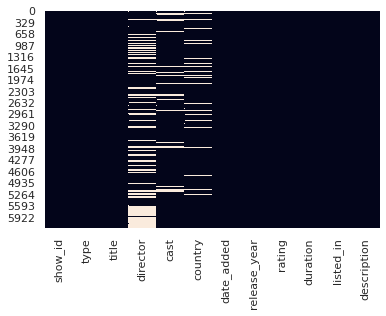

In [39]:
df = pd.read_csv('/kaggle/input/netflix-shows/netflix_titles.csv',parse_dates=True)

#only consider the year for the date_added column, and change all released dates to 2019
df['date_added']=pd.to_datetime(df['date_added']).dt.year
df.replace(to_replace=2020,value=2019,inplace=True)
sns.set(style='darkgrid')

print(df.info())
print(df.head())
sns.heatmap(df.isnull(),cbar=False)

The heatmap presents a large number of missing directors. 
From printing the head of the dataframe, the missing values are identified to belong to the TV shows.

For the next step, the popular countries are visualised in terms of number of TV shows and Movies.

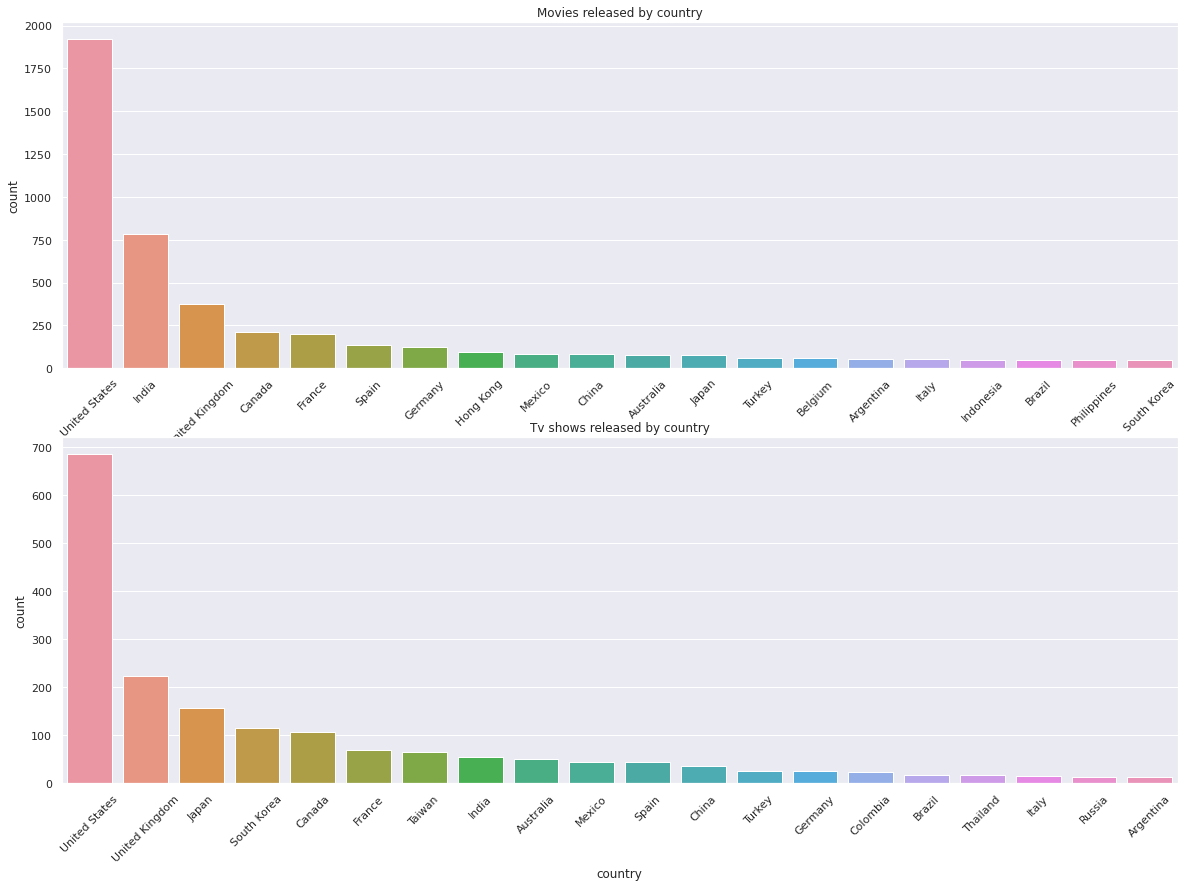

In [40]:
#the countries are separated using the explode method
df_country_explode_movie = df[df['type']=='Movie'].assign(country=df.country.str.split(', ')).explode('country')
df_country_explode_tv = df[df['type']=='TV Show'].assign(country=df.country.str.split(', ')).explode('country')

#an index is created with the 20 countries that released the largest amounts of movies and tv shows
df_countries_sum_movie = df_country_explode_movie.groupby(['country'])['listed_in'].count().sort_values(ascending=False)
df_countries_sum_tv = df_country_explode_tv.groupby(['country'])['listed_in'].count().sort_values(ascending=False)
idx_popular_countries_movies = df_countries_sum_movie.head(20).index
idx_popular_countries_tv = df_countries_sum_tv.head(20).index

#the exploded data is filtered according to these indexes
df_popular_movies = df_country_explode_movie[df_country_explode_movie.country.isin(idx_popular_countries_movies)]
df_popular_tv = df_country_explode_tv[df_country_explode_tv.country.isin(idx_popular_countries_tv)]

fig,ax = plt.subplots(2,1,figsize=[20,14])
sns.countplot(x='country',data=df_popular_movies,ax=ax[0],order=idx_popular_countries_movies)
sns.countplot(x='country',data=df_popular_tv,ax=ax[1],order=idx_popular_countries_tv)
ax[0].set_xticklabels(idx_popular_countries_movies,rotation=45)
ax[0].set_title('Movies released by country')
ax[1].set_xticklabels(idx_popular_countries_tv,rotation=45)
ax[1].set_title('Tv shows released by country')

plt.show()


We can now look at how the total number of TV shows and movies has changed through the years in the above countries. The following analysis is only considering the so-called "popular" countries.

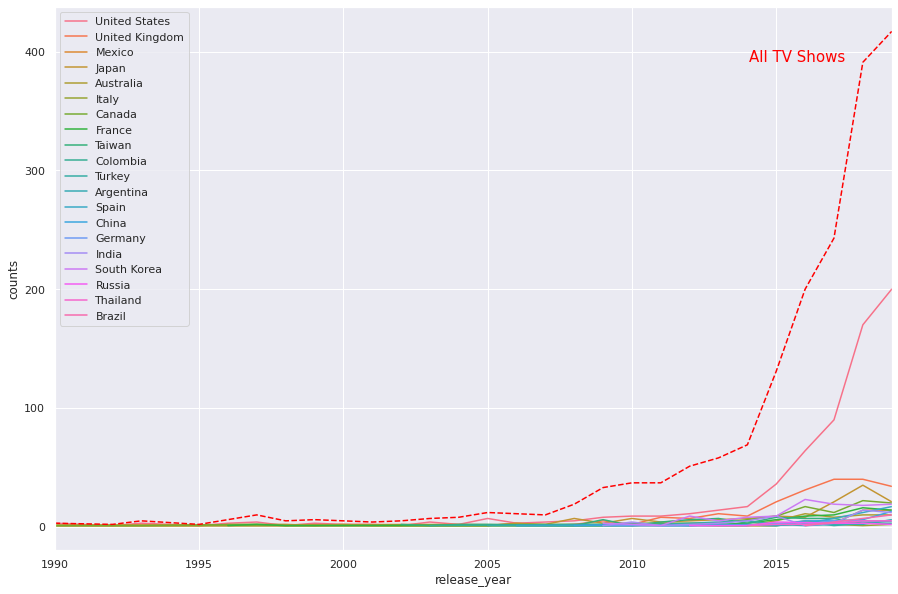

In [41]:
#how has the number of tv shows changed through the years? finding the number of tv shows per country first, and the total number after
df_year_tv = df_country_explode_tv[df_country_explode_tv.country.isin(idx_popular_countries_tv)]
df_year_country_tv = df_year_tv[df_year_tv['type']=='TV Show'].groupby(['release_year','country'])['show_id'].count().to_frame().reset_index()
df_year_all_tv = df_year_tv[df_year_tv['type']=='TV Show'].groupby(['release_year'])['show_id'].count().to_frame().reset_index()

df_year_country_tv.columns.values[2]='counts'
df_year_all_tv.columns.values[1]='counts'
fig, ax = plt.subplots(1,1,figsize=[15,10])
country_tv_shows = sns.lineplot(x='release_year',y='counts',data=df_year_country_tv,hue='country')
all_tv_shows = sns.lineplot(x='release_year',y='counts',data=df_year_all_tv,linestyle='--',color='red')
ax.text(0.83,0.9,'All TV Shows',transform=ax.transAxes,size=15,color='red')
plt.xlim(left=1990,right=2019)
plt.show()


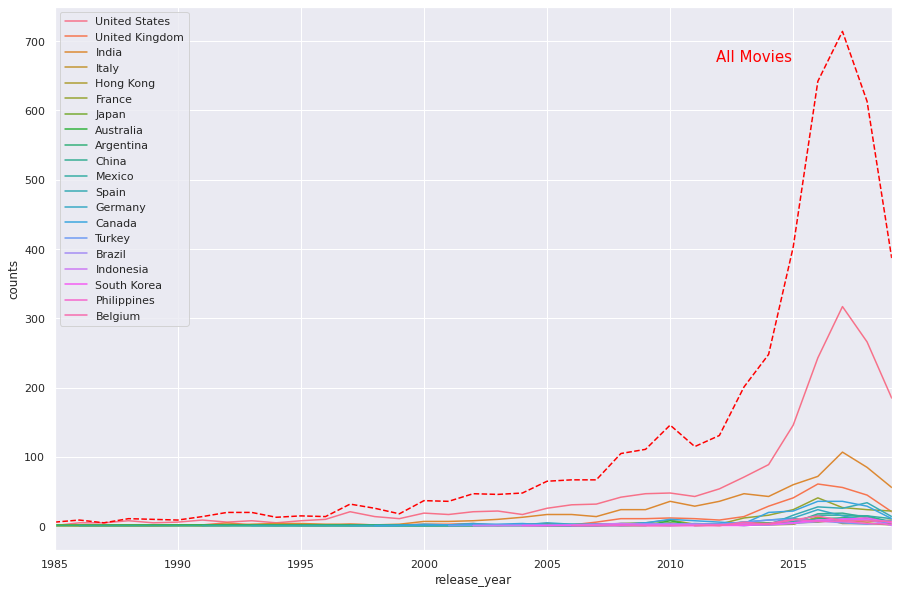

In [42]:
#same procedure is applied to movies
df_year_movies = df_country_explode_movie[df_country_explode_movie.country.isin(idx_popular_countries_movies)]
df_year_country_movies = df_year_movies[df_year_movies['type']=='Movie'].groupby(['release_year','country'])['show_id'].count().to_frame().reset_index()
df_year_all_movies = df_year_movies[df_year_movies['type']=='Movie'].groupby(['release_year'])['show_id'].count().to_frame().reset_index()

df_year_country_movies.columns.values[2]='counts'
df_year_all_movies.columns.values[1]='counts'

fig, ax = plt.subplots(1,1,figsize=[15,10])
country_movies_shows = sns.lineplot(x='release_year',y='counts',data=df_year_country_movies,hue='country')
all_movies_shows = sns.lineplot(x='release_year',y='counts',data=df_year_all_movies,linestyle='--',color='red')
ax.text(0.79,0.9,'All Movies',transform=ax.transAxes,size=15,color='red')
plt.xlim(left=1985,right=2019)
plt.show()

Using the same approach, we can separate each genre and look at how many entries each genre has every year between movies and TV shows. We are only considering the first 10 most popular genres.

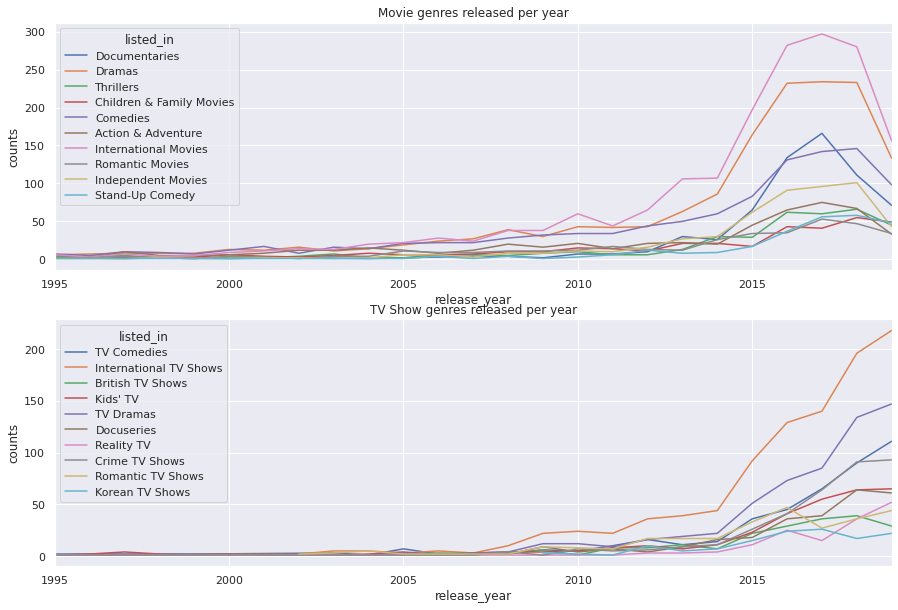

In [43]:
#we can analyse
df_genre_exp= df.assign(listed_in=df.listed_in.str.split(', ')).explode('listed_in')

idx_genre_movie = df_genre_exp[df_genre_exp['type']=='Movie'].groupby('listed_in')['show_id'].count().sort_values(ascending=False).head(10).index
idx_genre_tv = df_genre_exp[df_genre_exp['type']=='TV Show'].groupby('listed_in')['show_id'].count().sort_values(ascending=False).head(10).index

df_genre_movies = df_genre_exp[df_genre_exp.listed_in.isin(idx_genre_movie)]
df_genre_tv = df_genre_exp[df_genre_exp.listed_in.isin(idx_genre_tv)]

df_genres_count_movies = df_genre_movies[df_genre_movies['type']=='Movie'].groupby(['release_year','listed_in'])['show_id'].count().reset_index()
df_genres_count_tv = df_genre_tv[df_genre_tv['type']=='TV Show'].groupby(['release_year','listed_in'])['show_id'].count().reset_index()

df_genres_count_movies.columns.values[2]='counts'
df_genres_count_tv.columns.values[2]='counts'


fig, ax = plt.subplots(2,1,figsize=(15,10))
sns.lineplot(x='release_year',y='counts',data=df_genres_count_movies,hue='listed_in',ax=ax[0])
sns.lineplot(x='release_year',y='counts',data=df_genres_count_tv,hue='listed_in',ax=ax[1])
for axes in ax:
    axes.set_xlim(left=1995,right=2019)
    
ax[0].set_title('Movie genres released per year')
ax[1].set_title('TV Show genres released per year')

plt.show()

Similarly, we can look at genres by by date added.

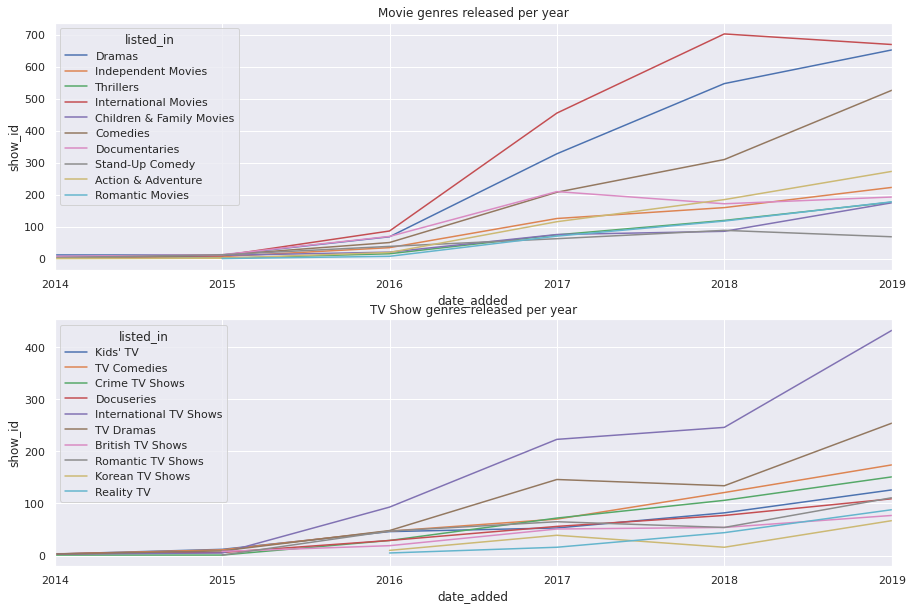

In [44]:
df_genres_count_movies_added = df_genre_movies[df_genre_movies['type']=='Movie'].groupby(['date_added','listed_in'])['show_id'].count().reset_index()
df_genres_count_tv_added = df_genre_tv[df_genre_tv['type']=='TV Show'].groupby(['date_added','listed_in'])['show_id'].count().reset_index()


fig, ax = plt.subplots(2,1,figsize=(15,10))
sns.lineplot(x='date_added',y='show_id',data=df_genres_count_movies_added, hue='listed_in',ax=ax[0])
sns.lineplot(x='date_added',y='show_id',data=df_genres_count_tv_added, hue='listed_in',ax=ax[1])
for axes in ax:
    axes.set_xlim(left=2014,right=2019)
ax[0].set_title('Movie genres released per year')
ax[1].set_title('TV Show genres released per year')

plt.show()

While the overall number of TV shows is lower, we can observe that they are being added in increasing amounts.
We can summarise the above findings in two graphs with the sums of all TV shows and movies by release date and date added.

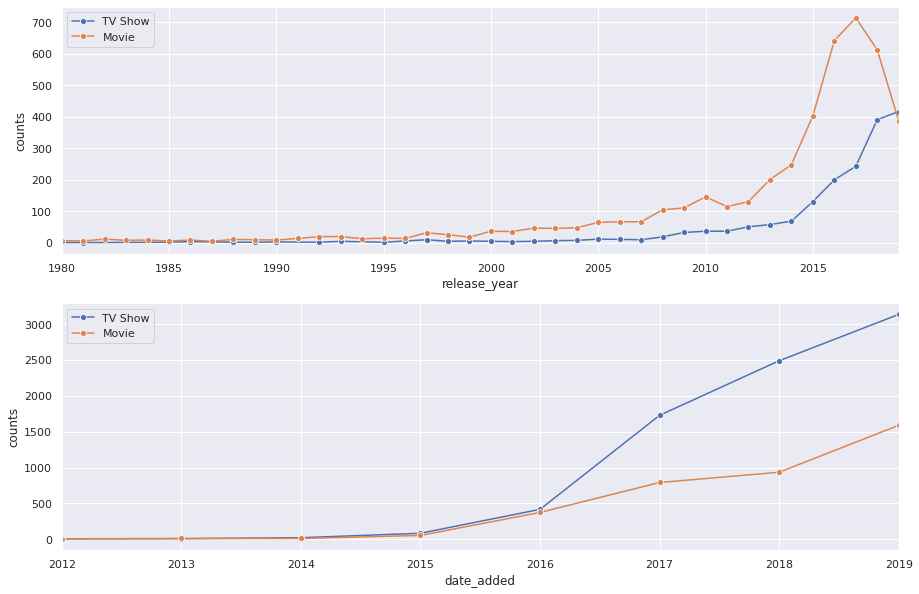

In [45]:
#summarising the above 
df_movies_added_sum = df_genres_count_movies_added.groupby('date_added').sum()
df_tv_added_sum = df_genres_count_tv_added.groupby('date_added').sum()
df_movies_added_sum.columns.values[0]='counts'
df_tv_added_sum.columns.values[0]='counts'

fix, ax=plt.subplots(2,1,figsize=(15,10))
sns.lineplot(x='release_year',y='counts',data=df_year_all_tv,ax=ax[0],label='TV Show', marker='o')
sns.lineplot(x='release_year',y='counts',data=df_year_all_movies,ax=ax[0],label='Movie',marker='o')
sns.lineplot(x='date_added',y='counts',data=df_movies_added_sum,ax=ax[1],label='TV Show',marker='o')
sns.lineplot(x='date_added',y='counts',data=df_tv_added_sum,ax=ax[1],label='Movie',marker='o')

ax[0].set_xlim(left=1980,right=2019)
ax[1].set_xlim(left=2012,right=2019)

plt.legend()
plt.show()

What about directors and actors? There are no directors listed for TV-shows, so these will only be analysed for movies. The .explode() method will be used to separate the directors in separate entries where multiple ones are listed. We are now considering all entries in the database for the next two analyses.

In [46]:
#25 directors with the highest number of movies
df_directors_exp = df.assign(director=df.director.str.split(', ')).explode('director')
df_directors= df_directors_exp[['show_id','type','director']]
df_directors = df_directors[df_directors['type']=='Movie']
df_directors= df_directors[~df_directors.duplicated(subset=['show_id'],keep='first')]
directors_count = (df_directors['director']).to_frame()
directors_count.columns.values[0]='director'
directors_count= directors_count['director'].value_counts().sort_values(ascending=False).to_frame().reset_index()
directors_count.columns.values[0]='director'
directors_count.columns.values[1]='number of movies'
directors_count = directors_count.set_index(np.arange(1,len(directors_count)+1))
print(directors_count.head(25))


               director  number of movies
1           Raúl Campos                18
2          Marcus Raboy                14
3             Jay Karas                14
4           Jay Chapman                12
5       Martin Scorsese                 9
6      Steven Spielberg                 9
7           Lance Bangs                 8
8          David Dhawan                 8
9            Johnnie To                 8
10      Shannon Hartman                 8
11       Yılmaz Erdoğan                 7
12          Hakan Algül                 7
13       S.S. Rajamouli                 7
14        Noah Baumbach                 7
15          Ryan Polito                 7
16     Robert Rodriguez                 7
17  Cathy Garcia-Molina                 7
18      Ram Gopal Varma                 6
19         Rocky Soraya                 6
20           Vlad Yudin                 6
21       Kunle Afolayan                 6
22         Robert Vince                 6
23           Matt Askem           

In [47]:
#same reasoning is applied to actors
df_cast_exp = df.assign(cast=df.cast.str.split(', ')).explode('cast')
df_cast= df_cast_exp[['show_id','type','cast']]
df_cast= df_cast[~df_cast.duplicated(subset=['show_id'],keep='first')]
cast_count = (df_cast['cast']).to_frame()
cast_count.columns.values[0]='actor'
cast_count= cast_count['actor'].value_counts().sort_values(ascending=False).to_frame().reset_index()
cast_count.columns.values[0]='actor'
cast_count.columns.values[1]='number of movies/shows'
cast_count = cast_count.set_index(np.arange(1,len(cast_count)+1))
print(cast_count.head(25))

                 actor  number of movies/shows
1       Shah Rukh Khan                      24
2         Akshay Kumar                      19
3   David Attenborough                      18
4     Amitabh Bachchan                      15
5         Nicolas Cage                      14
6         Adam Sandler                      13
7           Aamir Khan                      12
8          Anil Kapoor                      11
9          Samuel West                      10
10          Ajay Devgn                      10
11        Michela Luci                       9
12    Naseeruddin Shah                       9
13         Sanjay Dutt                       9
14          Will Smith                       8
15          Donnie Yen                       8
16             Prabhas                       8
17         Salman Khan                       8
18      Junko Takeuchi                       8
19          Mike Smith                       8
20         Jeff Dunham                       8
21       Saif

How is the duration of movies changing in time?

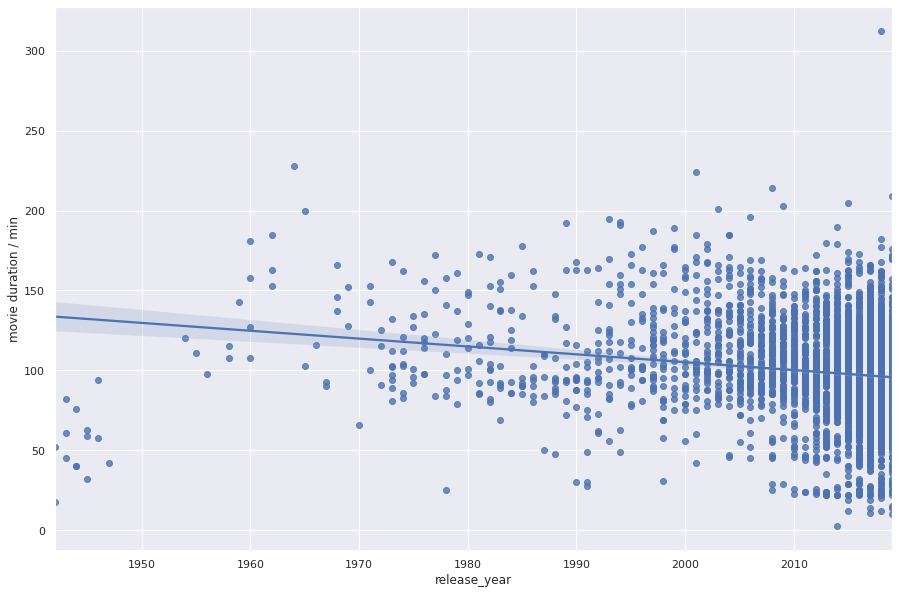

In [48]:
duration = df[['show_id','type','duration','release_year']]
duration_movie = duration[duration['type']=='Movie']
duration_tv = duration[duration['type']=='TV Show']

duration_movie['duration_int']= duration_movie['duration'].str.extract('(\d+)', expand=False)
duration_movie['duration_int'] = duration_movie['duration_int'].astype('int')

duration_tv['duration_int']= duration_tv['duration'].str.extract('(\d+)', expand=False)
duration_tv['duration_int'] = duration_tv['duration_int'].astype('int')
duration_tv = duration_tv[duration_tv['release_year']>2000]

duration_movie.columns.values[4]= 'movie duration / min'
duration_tv.columns.values[4]='number of seasons'
fig,ax=plt.subplots(1,1,figsize=(15,10))
sns.regplot(x='release_year',y='duration_int',data=duration_movie)
plt.show()

Movies seem to be getting shorter through the years, but TV shows have discrete number of seasons, so a swarmplot could be more appropriate.



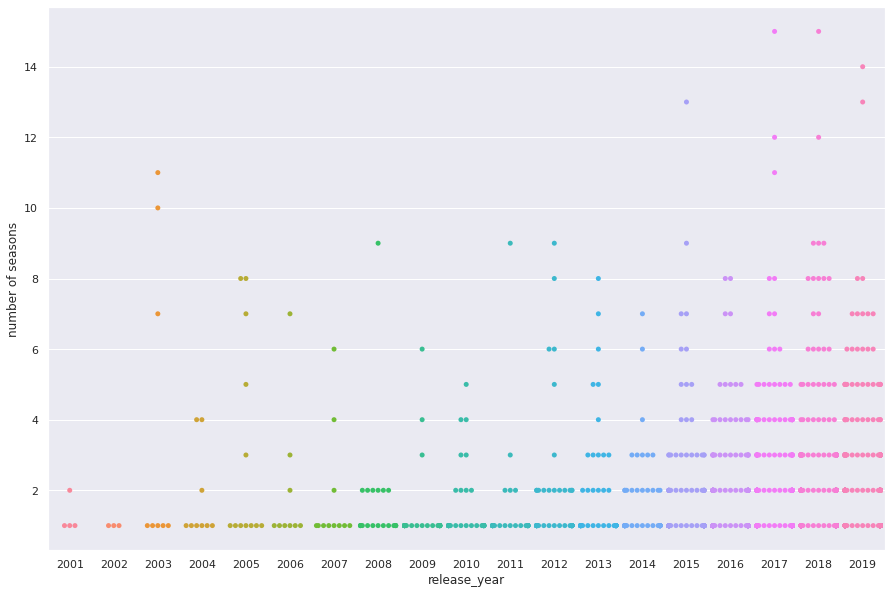

In [49]:
fig,ax=plt.subplots(1,1,figsize=(15,10))
sns.swarmplot(x='release_year',y='duration_int',data=duration_tv)
plt.show()

What about the longest film?

In [50]:
longest_film_id = duration_movie[duration_movie['duration_int']==max(duration_movie['duration_int'])].iloc[0,0]
longest_film = df[df['show_id']==longest_film_id]
print(longest_film[['title','duration']])


                           title duration
4315  Black Mirror: Bandersnatch  312 min


This was the interactive Black Mirror episode, what about an actual movie?

In [51]:
duration_movie_2=duration_movie.drop(index=4315)
longest_film_id = duration_movie_2[duration_movie_2['duration_int']==max(duration_movie_2['duration_int'])].iloc[0,0]
longest_film = df[df['show_id']==longest_film_id]
print(longest_film[['title','duration']])


       title duration
4227  Sangam  228 min
